In [1]:
#Load library and configuration parameters
#Denoising autoencoder
import torch
import torch.nn as nn
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import scipy.io as sio

import os
import cv2

In [2]:
# Classes

# Target dataset
class CustomDataset(Dataset):

    def __init__(self, only_train=True):
        
        target_path = '../11-Video_Feature_Generation/'
        data_meta = pd.read_csv(target_path +'output/scaled_objects/meta_data.csv')      
        self.data = []
        if only_train:
            n = data_meta[data_meta['test_train']=='test'].index[0]
        else:
            n = len(data_meta)
        # read all data 
        for i in range(0, n):
            img_path = target_path + data_meta.loc[i, 'scaled_im_path'][2:]
            class_name = data_meta.loc[i, 'name']
            self.data.append([img_path, class_name])
        # read class types
        tmp = data_meta[['name','class']].drop_duplicates().sort_values(by='class').reset_index(drop=True)
        class_map_ = dict()
        for i in range(0, len(tmp)):
            name_ = tmp.loc[i, 'name']
            class_ = int(tmp.loc[i, 'class'])
            class_map_[name_] = class_
        self.class_map = class_map_
        self.img_dim = (64, 64)
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        # read
        img = cv2.imread(img_path)
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize
        img = cv2.resize(img, self.img_dim)
        # normalize
        img = img/255.0
        # cast to float
        img = img.astype('float32')
        # expan dim
        img = np.expand_dims(img, axis=0)
        
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        
        return img_tensor, class_id
    
# Encoder settings
class Encoder(nn.Module):
    
    def __init__(self):
        
        super(Encoder,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv2 = nn.Sequential(
            torch.nn.Conv2d(64, 50, 3, 1, 1),  
            torch.nn.BatchNorm2d(50),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv3 = nn.Sequential(
            torch.nn.Conv2d(50, 36, 3, 1, 1),
            torch.nn.BatchNorm2d(36),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv4 = nn.Sequential(
            torch.nn.Conv2d(36,22, 3, 1, 1),  
            torch.nn.BatchNorm2d(22),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv5 = nn.Sequential(
            torch.nn.Conv2d(22, 8, 3, 1, 1),
            torch.nn.BatchNorm2d(8),
            torch.nn.Sigmoid())
        
        self.maxpool5 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
    def forward(self, x_in):
        
        x = self.conv1(x_in)
        x , indices1 = self.maxpool1(x)
        x = self.conv2(x)
        x , indices2 = self.maxpool2(x)
        x = self.conv3(x)
        x , indices3 = self.maxpool3(x)
        x = self.conv4(x)
        x , indices4 = self.maxpool4(x)
        x = self.conv5(x)
        feature , indices5 = self.maxpool5(x)
        
        indices = [indices1, indices2, indices3, indices4, indices5]
        
        return feature, indices
    
# Decoder settings
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder,self).__init__()
        
        self.convtrans1 = nn.Sequential(nn.ConvTranspose2d(8, 22, 3, 1, 1), )
        
        self.maxunpool1= nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans2 = nn.Sequential(nn.ConvTranspose2d(22, 36, 3, 1, 1), )
        
        self.maxunpool2 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans3 = nn.Sequential(nn.ConvTranspose2d(36, 50, 3, 1, 1), )
        
        self.maxunpool3 = nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans4 = nn.Sequential(nn.ConvTranspose2d(50, 64, 3, 1, 1), )
        
        self.maxunpool4 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans5 = nn.Sequential(nn.ConvTranspose2d(64, 1, 3, 1, 1), )
        
        self.maxunpool5 = nn.MaxUnpool2d(2,stride=2)
        
    def forward(self, x_in, indices):
        
        x = self.maxunpool1(x_in, indices[4])
        x = self.convtrans1(x)
        x = self.maxunpool2(x, indices[3])
        x = self.convtrans2(x)
        x = self.maxunpool3(x, indices[2])
        x = self.convtrans3(x)
        x = self.maxunpool4(x, indices[1])
        x = self.convtrans4(x)
        x = self.maxunpool5(x, indices[0])
        x = self.convtrans5(x)
        
        return x

In [3]:
#Configuration parameter

n_epoch = 20                # Number of epochs
batch_size = 128            # Size of the batch
learning_rate = 0.001       # learning rate for ADAM optimizer
noise_std = 0.01            # 
DAE_fig_upd_period = 10     # Every this variable batches, we will be saving the accumulated loss wwithin the batch

In [4]:
# Read Meta data 
data_meta = pd.read_csv('../11-Video_Feature_Generation/output/scaled_objects/meta_data.csv')

# Read Yolo Objects and create torch datasets
ped_2_train = CustomDataset(only_train=True)
train_loader = DataLoader(ped_2_train, batch_size = batch_size, shuffle=True)
ped_2_all = CustomDataset(only_train=False)
all_loader = DataLoader(ped_2_all, batch_size = batch_size, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.94s/it]


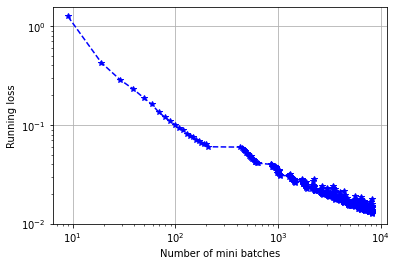

In [5]:
# Create the Autoencoder
encoder=Encoder().cuda()
decoder=Decoder().cuda()

# Loss functions and optimizers
parameters=list(encoder.parameters())+list(decoder.parameters())
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(parameters, lr=learning_rate)

# Autoencoder training

# Accumulators
batch_count = 0
running_loss = 0.0

# Create performance save arrays
xs = []
ys = []

for I in tqdm(range(n_epoch)):
    
    for image,label in train_loader:
        
        # create noise
        noise=torch.tensor(np.random.normal(loc=0, scale=noise_std, size=image.shape)).type(torch.FloatTensor)
        
        # create noise image
        image_n=torch.add(image, noise)
        
        # move images to GPU
        image=Variable(image).cuda()
        image_n=Variable(image_n).cuda()
        
        # run DAE
        latent_features, indices = encoder(image_n)
        output = decoder(latent_features, indices)
        
        # Get loss
        loss = loss_func(output,image)
        
        # Learning
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print progress
        running_loss += loss.item()
        if batch_count % DAE_fig_upd_period == DAE_fig_upd_period-1:    # every 1000 mini-batches...
            xs.append(I * len(train_loader) + batch_count)
            ys.append(running_loss)
            running_loss = 0.0
            
        # print one pass
        batch_count = batch_count+1
        
# create performance watch
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs,ys,'--*b')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Number of mini batches')
plt.ylabel('Running loss')
plt.grid()

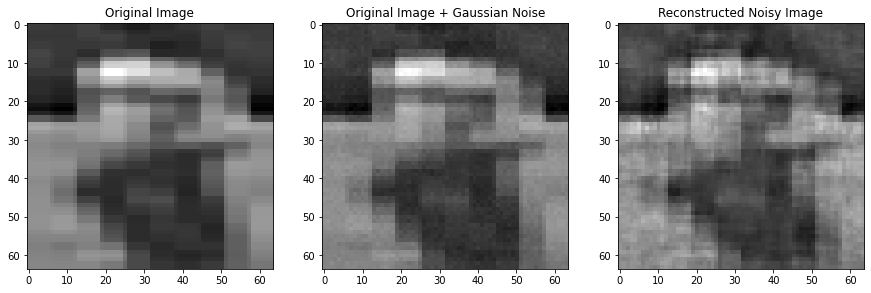

In [9]:
# Test couple of examples
test_image_index = 11
img=image[test_image_index].cpu()
input_img=image_n[test_image_index].cpu()
output_img=output[test_image_index].cpu()

origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()

f, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(origin[0],cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inp[0],cmap='gray')
axs[1].set_title('Original Image + Gaussian Noise')

axs[2].imshow(out[0],cmap='gray')
axs[2].set_title('Reconstructed Noisy Image')
plt.show()

In [7]:
# project all available data to latent space

n=len(ped_2_all)
latents = np.zeros((n, 32))

for i in tqdm(range(n)):
    
    # get the sample
    sample, _ = ped_2_all[i]
    sample = sample.cpu()
    tmp = np.expand_dims(sample, axis=0)   
    sample = torch.from_numpy(tmp)
    sample = Variable(sample).cuda()
    
    # get latent features
    latent_features, _ = encoder(sample)
    
    # save features
    latents[i,:] = latent_features.resize(1,32).cpu().detach().numpy()[0]
    
# combine meta data and latent features
latent_pd = pd.DataFrame(latents, columns=['dae_latent_feature_{:02d}'.format(x) for x in range(32)])
ped2_df = pd.concat([data_meta,latent_pd], axis=1)

  0%|                                                                                        | 0/56012 [00:00<?, ?it/s]c:\users\basarbatu\appdata\local\programs\python\python39\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
100%|███████████████████████████████████████████████████████████████████████████| 56012/56012 [02:48<00:00, 332.90it/s]


In [12]:
# save output as mat to be used in matlab

out_df = {name: col.values for name, col in ped2_df.items()}
sio.savemat('./output/ped2.mat', out_df)
sio.savemat('C:/Users/basarbatu/Desktop/phd/02-research/10-Video-NP/data/raw/ped2.mat', out_df)